In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [2]:
mb_size=64
transform=transforms.Compose([transforms.ToTensor()])

trainset= torchvision.datasets.MNIST(root='./NewData',download=True,train=True,transform=transform)

trainloader=torch.utils.data.DataLoader(trainset,shuffle=True,batch_size=mb_size)


100%|█████████▉| 9904128/9912422 [00:16<00:00, 197370.43it/s] 

Extracting ./NewData\MNIST\raw\train-images-idx3-ubyte.gz to ./NewData\MNIST\raw



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]
32768it [00:01, 31241.44it/s]                           


Extracting ./NewData\MNIST\raw\train-labels-idx1-ubyte.gz to ./NewData\MNIST\raw



0it [00:00, ?it/s]
 40%|████      | 663552/1648877 [00:11<00:20, 47392.03it/s]
9920512it [00:30, 197370.43it/s]                             
 99%|█████████▉| 1638400/1648877 [00:20<00:00, 204257.18it/s]

Extracting ./NewData\MNIST\raw\t10k-images-idx3-ubyte.gz to ./NewData\MNIST\raw




0it [00:00, ?it/s]

  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./NewData\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./NewData\MNIST\raw
Processing...
Done!



1654784it [00:31, 204257.18it/s]                             

torch.Size([64, 784])


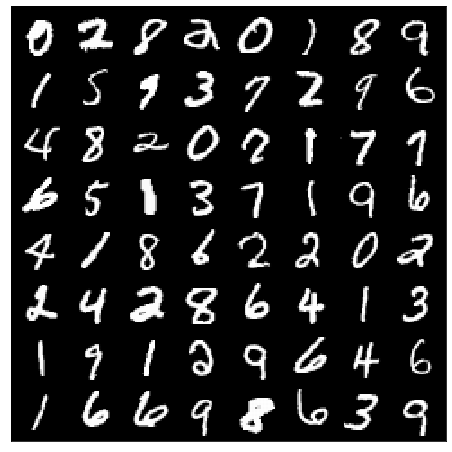

In [3]:
data_iter=iter(trainloader)
images,labels=data_iter.next()
test=images.view(images.size(0),-1)
print(test.size())

Z_dim=100
X_dim=test.size(1)


def imshow(img):
    im = torchvision.utils.make_grid(img)
    npimg = im.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.xticks([])
    plt.yticks([])

    plt.show()

imshow(images)
h_dim=128    

In [4]:
def init_weight(m):
  if type(m)==nn.Linear:
    nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0)

class Gen(nn.Module):
    def __init__(self):
        super(Gen,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(Z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, X_dim),
            nn.Sigmoid()
        )
          
    def forward(self, input):
        return self.model(input)

In [5]:
class Dis(nn.Module):
    def __init__(self):
        super(Dis,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, input):
         return self.model(input)

In [6]:
G=Gen()
D=Dis()

lr=1e-3
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

Epoch:0,   G_loss:0.0,    D_loss:0.0


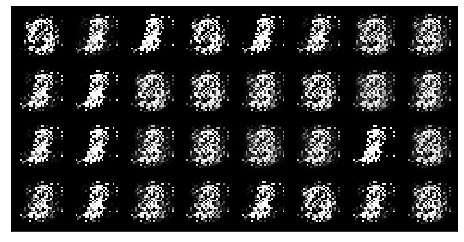

Epoch:1,   G_loss:0.0,    D_loss:0.0


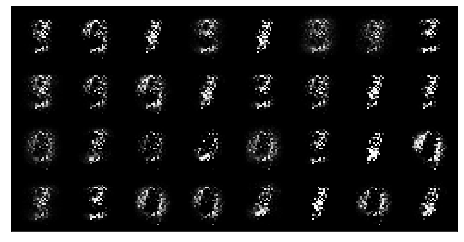

In [7]:
for epoch in range(2):
    G_loss_run = 0.0
    D_loss_run = 0.0
    for i, data in enumerate(trainloader):
        X, _ = data
        mb_size = X.size(0)
        X = X.view(X.size(0), -1)
        
        one_labels = torch.ones(mb_size, 1)
        zero_labels = torch.zeros(mb_size, 1)
        
        z = torch.randn(mb_size, Z_dim)
        G_sample=G(z)
        D_fake = D(G_sample)
        D_real = D(X)
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)
        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_loss = D_real_loss + D_fake_loss
        
        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()
        
        z = torch.randn(mb_size, Z_dim)
        G_sample=G(z)
        D_fake = D(G_sample)
        G_loss = F.binary_cross_entropy(D_fake, one_labels)
        
        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()
        
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, G_loss_run/(i+1), D_loss_run/(i+1)))
    
    samples = G(z).detach()
    samples = samples.view(mb_size, 1, 28, 28)
    imshow(samples)